# Модель определения момента первого прихода взрывной волны

## Постановка задачи

Выделить на сейсмической трассе момент первого приходы взрывной волны

## Датасет
2D сейсмограммы валынтойского участока.

Загрузка SPS файлов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from hmmlearn import hmm

from dataset import Dataset, Pipeline, B, V

from field_index import FieldIndex
from seismic_batch import SeismicBatch
from utils import get_file_by_index
from hmm_model import HMModel, make_hmm_data

dfr = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_R_utm.txt', sep='\s+', header=None)
dfr.columns = ['rline', 'rid', 'x', 'y', 'z']
dfr = dfr.astype({'rid': np.int32, 'x': np.float32, 'y': np.float32, 'z': np.float32})

dfs = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_S_utm.txt', sep='\s+', header=None)
dfs.columns = ['sline', 'sid', 'point_index', 'sht_depth', 'uphole', 'x', 'y', 'z']
dfs = dfs.dropna(axis=0)
dfs = dfs.astype({'sid': np.int32, 'point_index': np.int8, 'sht_depth': np.float32,
                  'uphole': np.float32, 'x': np.float32, 'y': np.float32, 'z': np.float32})

dfx = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_X.sps',
                  sep='\s+', header=None, skiprows=49)
dfx.columns = ['tape', 'xid', 'sline', 'sid', 'from_channel', 'to_channel', 'rline',
               'from_receiver', 'to_receiver']
dfx['sline'] = dfx['sline'].apply(lambda x: "S" + str(x))
dfx['rline'] = dfx['rline'].apply(lambda x: "R" + str(x))
dfx = dfx.astype({'xid': np.int32, 'sid': np.int32,
                  'from_channel': np.int16, 'to_channel': np.int16,
                  'from_receiver': np.int32, 'to_receiver': np.int32})

Фильтрация активного профиля

In [2]:
dfx37 = dfx[dfx['sline'] == 'S37']

Индексация сейсмограмм

In [3]:
shot_index = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx37)

Создание датасета

In [4]:
shot_set = Dataset(shot_index, SeismicBatch)

Загрузка батча из 10 сейсмограмм

In [5]:
path = '/home/egor/Desktop/2D_Valyton/prof_37/segy/'
batch_size = 10

batch = (shot_set.next_batch(batch_size)
        .load(path=path, fmt='segy', sort_by='channel',
              get_file_by_index=get_file_by_index, skip_channels=2)
        .to_2d())

Просмотр одной из загруженных сейсмограмм

<IPython.core.display.Javascript object>


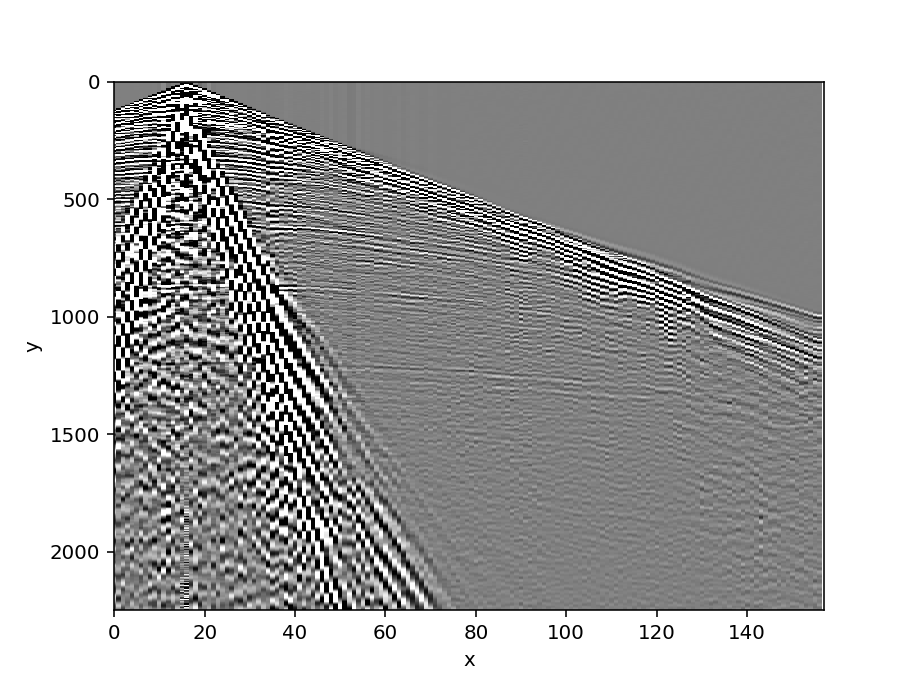

In [8]:
%matplotlib notebook

cv = 3
batch.show_slice(batch.indices[8], vmin=-cv, vmax=cv, cmap='gray')

Для обучения используется одна сейсмограмма

In [12]:
shot_set.split(shares=1 / len(shot_set))

len(shot_set.train), len(shot_set)

(1, 402)

## Архитектура

Используется модель скрытой марровской цепи с двумя состояниями. Предполагается, что состояние один тип состояний отвечает полезному сигналу, другой - внешним шумам. Первый момент перехода из состояния "шум" в состояние "полезный сигнал" должен отвечать моменту первого прихода взрывной волны. Предполагается, что в начальный момент времени состояние "шум" должно быть наиболее вероятно.

Конфигурация модели

In [9]:
config_train = {
    'build': True,
    'estimator': hmm.GaussianHMM(n_components=2, n_iter=100, covariance_type="full")
}

## Обучение

Пайплайн обучения модели

In [13]:
cv = 3

train_pipeline = (Pipeline()
                 .init_model("dynamic", HMModel, "HMM", config=config_train)
                 .load(path=path, fmt='segy', sort_by='channel',
                       get_file_by_index=get_file_by_index, skip_channels=2)
                 .to_2d()
                 .apply_transform(np.clip, a_min=-cv, a_max=cv, src="traces", dst="traces")
                 .gradient(src="traces", dst="grad")
                 .cwt(src="grad", dst="wavelet", scales=[8], wavelet="mexh")
                 .train_model("HMM", make_data=partial(make_hmm_data, components='wavelet'))
                 .run(batch_size=1, n_epochs=1, shuffle=False, drop_last=False, lazy=True))

Запуск обучения на 1 сейсмограмме

In [14]:
(shot_set.train >> train_pipeline).run()

Сохранение обученной модели

In [15]:
train_pipeline.save_model("HMM", path="hmmodel.dill")

## Инференс

Конфигурация модели для инференса

In [17]:
config_predict = {
    'build': False,
    'load': {'path': "hmmodel.dill"}
}

Пайплайн для инференса с размером батча 50

In [18]:
batch_size = 50

predict_pipeline = (Pipeline()
                   .init_model("static", HMModel, "HMM", config=config_predict)
                   .init_variable('predictions', init_on_each_run=list)
                   .load(path=path, fmt='segy', sort_by='channel',
                         get_file_by_index=get_file_by_index, skip_channels=2)
                   .to_2d()
                   .apply_transform(np.clip, a_min=-cv, a_max=cv, src="traces", dst="traces")
                   .gradient(src="traces", dst="grad")
                   .cwt(src="grad", dst="wavelet", scales=[8], wavelet="mexh")
                   .predict_model("HMM", make_data=partial(make_hmm_data, components='wavelet'),
                                  save_to=V("predictions"), mode='w')
                   .run(batch_size=batch_size, shuffle=False, drop_last=False, n_epochs=1, lazy=True))

Связывание датасета с пайплайном

In [19]:
predict_pipeline = (shot_set.test >> predict_pipeline)

Прогон одного батча через пайплайн

In [20]:
batch = predict_pipeline.next_batch()

Сбор созраненных предсказаний модели

In [21]:
predictions = predict_pipeline.get_variable('predictions')

Веделение первых моментов перехода из состояния "шум" в состояние "полезный сигнал"

In [23]:
signal_label = np.argmin(train_pipeline.get_model_by_name("HMM").estimator.startprob_)

def get_first_arrival(annot, signal_label):
    indices = np.where(annot == signal_label)[0]
    return indices[0] if len(indices) else -1

picks = np.split(np.array([get_first_arrival(annot, signal_label) for annot in predictions]),
                 np.cumsum([len(t) for t in batch.traces]))

Просмотр сейсмограмм и полученных значений для первых моментов

In [24]:
%matplotlib notebook

i = 10

plt.imshow(pbatch.traces[i].T, cmap='gray')
plt.scatter(np.arange(len(picks[i])), picks[i], s=10, c='r')
plt.axes().set_aspect('auto')
plt.show()

NameError: name 'pbatch' is not defined